In [3]:
import numpy as np
import scipy
from scipy import integrate
from numpy.random import default_rng
from multiprocessing import Pool
import nfwFunctions as NFW
import inverseTransform
import time

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

<h1>Making an NFW halo</h1>

<h2>Important equations:</h2>

mass density $\rho (r)$:
\begin{equation}
\rho (r) = \frac{\rho_o}{\frac{r}{a}\left(1+\frac{r}{a}\right)^2}
\end{equation}

total mass at radius r $M (r)$:
\begin{equation}
M (r) = 4 \pi \rho_o a^3 \left( ln\left(1+\frac{r}{a}\right) - \frac{\frac{r}{a}}{1+\frac{r}{a}}\right)
\end{equation}

potential at radius r $\Phi (r)$:
\begin{equation}
\Phi (r) = -4 \pi G \rho_o a^2 \frac{ln\left(1+\frac{r}{a}\right)}{\frac{r}{a}}
\end{equation}

We can define some distant radius $r_\Delta$ where $\rho (r_\Delta)=\Delta\cdot\rho_c$ where $\rho_c$ is the cosmological critical density and $\Delta$ is some number, usually 200. This radius $r_\Delta$ is usually quite a bit bigger than the scale radius a, and the ratio between these quantities is usually characterized by the "concentration" of the halo:
$c=\frac{r_\Delta}{a}$

<h2>Generating the radial distribution</h2>
The differential bit of mass contained in a shell of thickness dr at radius r is given by:
\begin{equation}
    dM(r) = 4\pi r^2 \rho (r) dr.
\end{equation}

Integrating this differential shell of mass up to some radius tells how much mass in enclosed in a volume up to a certain volume. Dividing by some total mass (defined by the mass enclosed at $r_\Delta$) we now have an idea of what fraction of mass is enclosed up to any radius. This is equivalent to the cumulative distribution function for the radius of tracers in the halo:
\begin{equation}
    \text{CDF(r)} = \frac{M(r)}{M(r_{200})} = \frac{\int_0^r {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'} {\int_0^{r_{200}} {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'}
\end{equation}

We can pick a radius at random, but that will only create a flat probability distribution in r. We need a way to systematic way to encode the bumpiness of the distribution in our random number generation. Since we can explicitly compute the CDF we can sample a better way: inverse transform sampling.

The CDF for the radii of tracers in the halo can be written in terms of nice dimensionless variables:
\begin{equation}
    \text{CDF}(\chi) = \frac{ln(1+c\chi) - \frac{c\chi}{1+c\chi}} {ln(1+c) - \frac{c}{1+c}};\:(0<\chi<1)
\end{equation}

where $\chi=\frac{r}{r_\Delta}$ and $c=\frac{r_\Delta}{a}$ (as previously defined).

<h2>Generating the velocity distribution</h2>
We're assuming a Maxwell-Boltzmann distribution for the speeds of the tracer stars, so we can suppose that the radial velocities of the tracers are given by a one-dimensional MB-distribution such as:
\begin{equation}
    f(v_r) = \left(\frac{m}{2\pi k T}\right)^{1/2} e^{-\frac{mv_r^2}{2kT}}
\end{equation}
The first moment of this distribution is clearly zero (it is even about zero), but its second moment is quite useful. This is given by:
\begin{equation}
    \sigma_{v_r}^2 = \frac{kT}{m}.
\end{equation}
For an NFW profile, the halotools documentation claims that $\sigma_{v_r}^2$ is also given by:
\begin{equation}
    \sigma_{v_r}^2 = V_{virial}^2 \frac{c^2 \chi (1+c \chi)^2}{g(c)} \int_{c\chi}^{\infty} \frac{g(y)}{y^3(1+y)^2}dy.
\end{equation}
Note that this integral sucks, here is it's explicit form:
\begin{equation}
\frac{6 (c\chi+1)^2 (c \chi)^2 \text{Li}_2(-(c \chi))+\pi ^2 (c \chi)^4+3 (c \chi)^4 \log ^2((c \chi)+1)+(c \chi)^4 \log ((c \chi)+1)+2 \pi ^2 (c \chi)^3-7 (c \chi)^3+6 (c \chi)^3 \log ^2((c \chi)+1)-4 (c \chi)^3 \log ((c \chi)+1)+\pi ^2 (c \chi)^2-9 (c \chi)^2+3 (c \chi)^2 \log ^2((c \chi)+1)-((c \chi)+1)^2 (c \chi)^2 \log ((c \chi))-8 (c \chi)^2 \log ((c \chi)+1)-(c \chi)-2 (c \chi) \log ((c \chi)+1)+\log ((c \chi)+1)}{2 (c \chi)^2 ((c \chi)+1)^2}
\end{equation}

The $\text{Li}_2(-(c \chi))$ part is probably the worst, it's the polylog function (of 2nd order, or something). I'm pretty sure a computer could numerically integrate this faster than it could actually evaluate this explicit form, maybe I'll compare them sometime but for now, revel in it's horror. I will numerically integrate to get sigma.

As a quick note, I don't totally understand the argument provided by halotools in deriving this and need to think about it some more.
Some relevant links:

<b>Method in halotools:</b>
https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.NFWPhaseSpace.html#halotools.empirical_models.NFWPhaseSpace.radial_velocity_dispersion

<b>Explanation from halotools:</b>
https://halotools.readthedocs.io/en/latest/source_notes/empirical_models/phase_space_models/nfw_profile_source_notes.html#modeling-the-nfw-velocity-profile

<b>If there's one obvious failure point in my process to generate the velocity profile, I would guess that it's probably here in how I define these dispersions..</b>

The g function is a real time-saver for most things NFW, defined as:
\begin{equation}
    g(x) = \ln(1+x) - \frac{x}{1+x}.
\end{equation}
Although we ultimately want the speed distribution, we looked at the distribution of radial velocities since we knww how to calculate $\sigma_{v_r}^2$. Now we can relate $\sigma_{v_r}^2$ to temperature T and plug this into the speed-version of the Maxwell-Boltzmann distribution (this is the other potential failure point of my method, but I am still unsure) to get:
\begin{equation}
    f(v) = \left(\frac{m}{2\pi k T}\right)^{3/2}4\pi v^2 e^{-\frac{mv^2}{2kT}} = \left(\frac{1}{2\pi \sigma_{v_r}^2}\right)^{3/2}4\pi v^2 e^{-\frac{v^2}{2 \sigma_{v_r}^2}}.
\end{equation}
Note that $\sigma_{v_r}^2$ must be calculated at each radius, thus the dispersion and the speed distribution is a rather complicated function of radii. We'll need to numerically integrate the definition of $\sigma_{v_r}^2$ every time we want it, and then we have to feed that value into $f(v)$ to get the proper PDF for the tracer speeds.

Once we have the speeds for each tracer (using inverse transform sampling), it's a trivial matter to generate their velocities. We can just pick a direction for each tracer by choosing the pairs of spherical angles at random. Note, the polar angle needs to be picked in a clever way to avoid crowding at the poles. When this is finished, we will have generated the positions of each tracer as well as their velocities, providing us with the full 6D phase space of this NFW halo.

<h2>Validation note</h2>
4/15/21, I've checked all of these equations and I don't think that there are any typos anymore. I still need to see if these distributions generate a phase space distribution that obeys the collisionless Boltzmann equation. Have been struggling to write f down explicitly. I should just need the coordinate space density function and the velocity space distribution function, so hopefully I can figure out how to extract those from what I've derived.

<h2>The Phase Space Distribution Function</h2>
Binney and Tremaine describe a function $f(\textbf{x},\textbf{v},t)$ that satisfies:
\begin{equation}
\int d^3\textbf{x}d^3\textbf{v}\:f(\textbf{x},\textbf{v},t) =1.
\end{equation}
I want to know how I should write f in terms of all of the functions I've already found, such as the probability distribution function for the radius and speed. There are assumptions that I've made about angular distributions for both speed and velocity that also need to be encoded.

I also know that I should be able to write:
\begin{equation}
\nu(\textbf{x}) = \int d^3\textbf{v} \: f(\textbf{x},\textbf{v}).
\end{equation}
Where $\nu(\textbf{x})$ is the probability per unit volume (spatial volume) of finding a particular star at $\textbf{x}$ regardless of its velocity. I've dropped the explicit time dependence from f as well, since these distributions should be static. I'm pretty sure that $\nu(\textbf{x})$ is going to be very closely related to the PDF for radii, just with an extra factor of r^2 and some constants to get the units right. I'll check what function gives me 1 when integrated over all space (since $\int d^3\textbf{x} \nu(\textbf{x}) = 1$ by definition of f). I got it! It should have been obvious, I just needed to divide the mass density distribution by the total mass. I integrated just to check that the factors were right, and they were, so here it is:
\begin{equation}
\nu(\textbf{x}) = \nu(r) = \frac{1}{4\pi a^2 g(c) r (1+\frac{r}{a})^2}
\end{equation}
That only leaves the hard part! What function gives me the probability to have a particular velocity (vector) $\textbf{v}$ at a given position $\textbf{x}$ (or really just r, but formally it's the position vector). I have the probability distribution function to have a particular speed at a given value of r, but again that's not exactly what I need. I need a function that, at a given $\textbf{x}$, may be integrated over all possible velocities to give 1 i.e.
\begin{equation}
\int d^3\textbf{v}\:h(\textbf{x},\textbf{v}) =1.
\end{equation}
I'm calling this function h. This property should follow from the overall density function integrating to 1 over all phase space and the fact that $\nu(\textbf{x})$ integrates to 1 over all coordinate space. This tells us that the function h integrated over all velocities cannot be anything other than 1, otherwise the density function integral (after it has been evaluated for v) would have another function multiplying $\nu(\textbf{x})$. But $\nu(\textbf{x})$ has to be alone in the integrand for the integral over all coordinate space to give 1, so the above equation must follow.

Okay, I think I was wrong about the speed pdf not being what I want, I think it's (almost) exactly what I want! I noticed that when you integrate the speed pdf (divided by $4\pi v^2$) over all velocities, you get 1. The only catch is you have to assume the maximum speed is infinite, but we usually do cut the speed off at the kinematic limit. This limit is usually large, and I haven't seen the PDF take on large values near that limit yet so I think it's okay for now. So we have our h! It must be:
\begin{equation}
h(v,r) = \left(\frac{1}{2\pi\sigma^2(r)}\right)^\frac{3}{2} e^{-\frac{v^2}{2\sigma^2(r)}}
\end{equation}

Not too bad. We can combine these now to get f, our phase space density function! Exciting. The density function $f(\textbf{x},\textbf{v})$ must be:
\begin{equation}
f(\textbf{x},\textbf{v}) = \nu(r) * h(v,r) = \frac{1}{4\pi a^2 g(c) r (1+\frac{r}{a})^2} * \left(\frac{1}{2\pi\sigma^2(r)}\right)^\frac{3}{2} e^{-\frac{v^2}{2\sigma^2(r)}}
\end{equation}
where $\sigma(r)^2 = V_{virial}^2 \frac{c \frac{r}{a} (1+\frac{r}{a})^2}{g(c)} \int_{\frac{r}{a}}^{\infty} \frac{g(y)}{y^3(1+y)^2}dy$ as found before. I'm going to write this down and type up a cleaner version here.

\begin{equation}
f(r,v) = \frac{\rho(r) e^{\frac{-v^2}{2\sigma(r)^2}}}{\sqrt{128 \pi^5} \rho_0 a^3 \sigma(r)^3 g(c)}
\end{equation}

Now we can plug this thing into the collisionless Boltzmann equation and pray that it actually works.

Update: I have no idea if this works, I tried plugging it into the collisionless Boltzmann equation in spherical coordinates and kept things as nice as I could, but it still got out of hand. My main concern is the complicated form for sigma, but there seem to be other terms that don't appear to cancel.

In [7]:
class haloNFW(): # Our NFW halo object
    def __init__(self, nTracers, rScale, rho0, delta, rhoCritical = 1.26*10**-7, useParallel = True, numThreads = 4):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        """
        self.nTracers = nTracers # number of tracer stars. Halo attribute 0
        self.rScale = rScale # scale radius for NFW profile, this is sometimes called a. Halo attribute 1
        self.rho0 = rho0 # scale density for NFW profile. Halo attribute 2
        self.delta = delta # cutoff scale. Halo attribute 3
        self.rhoCritical = rhoCritical # Halo attribute 4
        rhoNorm = self.rho0/(self.delta*self.rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        self.c = ( cShortcut + 1./cShortcut - 2 )/3. # Halo attribute 5
        self.rDelta = self.c*self.rScale # Halo attribute 6
        self.G = 4.3009*10**-3 # Newton's constant, (pc/solar mass) * (km/second)^2. Halo attribute 7
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*NFW.gFcn(self.c) # Should be in units of solar masses. Halo attribute 8
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta) # Halo attribute 9
        
        self.haloAttributes = np.array((self.nTracers,self.rScale,self.rho0,self.delta,self.rhoCritical,self.c,self.rDelta,self.G,self.mHalo,self.virialSpeed))
        self.nt = numThreads
        self.useParallel = useParallel
        
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radiiNorm = np.zeros(self.nTracers)
        if self.useParallel==True:
            if __name__ == '__main__':
                with Pool(processes=self.nt) as pool:
                    result_list = []
                    for k in range(self.nt):
                        result_list.append(
                            pool.apply_async(
                                inverseTransform.inverseTransformSamplingRadius,
                                (len(np.arange(k,nTracers,self.nt)),
                                 self.haloAttributes,
                                 (0,1),
                                 self.rScale/self.rDelta,
                                 .5*(self.rScale/self.rDelta+1)
                                 ,
                                )
                            )
                        )
                    for k in range(self.nt):
                        self.radiiNorm[np.arange(k,nTracers,self.nt)]=result_list[k].get()
                    pool.close()
                    pool.join()
        else:
            self.radiiNorm = np.array(inverseTransform.inverseTransformSamplingRadius(self.nTracers, self.haloAttributes, bracket = (0, 1), x0=self.rScale/self.rDelta, x1=.5*(self.rScale/self.rDelta+1)))
        self.radii = self.radiiNorm * self.rDelta
        self.coordAngles = np.array([np.arccos(2*default_rng().uniform(0,1,self.nTracers)-1),default_rng().uniform(0,1,self.nTracers)*2*np.pi]) # first row is theta, second row is phi
        
    def genTracerVelocities(self):
        """
        This should build a list of tracer speeds + directions using the speedCDF we define earlier via inverse transform sampling.
        """
        self.speeds = np.zeros(self.nTracers)
        if self.useParallel==True:
            if __name__ == '__main__':
                with Pool(processes=self.nt) as pool:
                    result_list = []
                    for k in range(self.nt):
                        result_list.append(
                            pool.apply_async(
                                inverseTransform.inverseTransformSamplingVelocity,
                                (
                                    len(np.arange(k,nTracers,self.nt)),
                                    self.haloAttributes,
                                    self.radiiNorm[np.arange(k, nTracers, self.nt)],
                                )
                            )
                        )
                    for k in range(self.nt):
                        self.speeds[np.arange(k,nTracers,self.nt)]=result_list[k].get()
                    pool.close()
                    pool.join()
        else:
            self.speeds = np.array(inverseTransform.inverseTransformSamplingVelocity(nTracers, self.haloAttributes, self.radiiNorm))
        self.velocityAngles = np.array([np.arccos(2*default_rng().uniform(0,1,self.nTracers)-1),default_rng().uniform(0,1,self.nTracers)*2*np.pi]) # first row is theta, second row is phi
        
    def genTracers(self):
        """
        Should automatically generate a full set of tracer particles with coordinates and velocities that obey an NFW profile.
        """
        print("Generating " + str(self.nTracers) + " coordinates, please wait...")
        time0=time.time()
        self.genTracerCoords()
        time1=time.time()
        print("Coordinates generated in " + str(round(time1-time0,2)) + " seconds.")
        print("Generating " + str(self.nTracers) + " velocities, please wait...")
        time0 = time.time()
        self.genTracerVelocities()
        time1 = time.time()
        print("Velocities generated in " + str(round(time1-time0,2)) + " seconds.")
        self.sphericalPhaseSpacePoints = [self.radii,
                                          self.coordAngles[0,:],
                                          self.coordAngles[1,:],
                                          self.speeds,
                                          self.velocityAngles[0,:],
                                          self.velocityAngles[1,:]
                                         ]
        self.cartesianPhaseSpacePoints = [self.radii*np.cos(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.sin(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.cos(self.coordAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.sin(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[0,:])
                                         ]
        print("All " + str(self.nTracers) + " tracers generated.")
        
    def saveHalo(self):
        """
        Saves a copy of the tracer information. Right now loading these in seems to be bugged.
        """
        t = time.localtime()
        timestamp = time.strftime('%b_%d_%Y_%H%M', t)
        metaLabels = np.array(('nTracers','rScale','mwHaloDensity','delta','criticalDensity'))
        haloAttrib = np.array((self.nTracers,self.rScale,self.rho0,self.delta,self.rhoCritical))
        phaseSpaceLabels = np.array(('x_pc','y_pc','z_pc','vx_km_s','vy_km_s','vz_km_s'))
        np.savez('generatedHalos//nfwGeneratedTracers_'+timestamp,metaLabels,haloAttrib,phaseSpaceLabels,self.cartesianPhaseSpacePoints)

In [13]:
# Let's make a halo!

# Halo parameters
nTracers = 10**5
rScale = 8.1*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

# Create an instance of the haloNFW class
mwHalo = haloNFW(nTracers,rScale,mwHaloDensity,delta,criticalDensity,useParallel=True,numThreads=6)

# Print out some information about the halo
print('rScale is : '+str(mwHalo.rScale),', rDelta is: ' + str(mwHalo.rDelta))
print('the concentration must then be: ' + str(mwHalo.c))

# Generates the 6D coordinates of nTracer # of tracers using the provided characteristics of the halo.
mwHalo.genTracers()

# Saving the generated halo so we can load it up in another file
saveHalo = True
if saveHalo == True:
    mwHalo.saveHalo()

rScale is : 8100.0 , rDelta is: 48041.27060252
the concentration must then be: 5.931021062039506
Generating 100000 coordinates, please wait...
Coordinates generated in 5.36 seconds.
Generating 100000 velocities, please wait...
Velocities generated in 10.51 seconds.
All 100000 tracers generated.


<h1>Tracer Coordinates</h1>

Text(0.5, 0, 'Z (pc)')

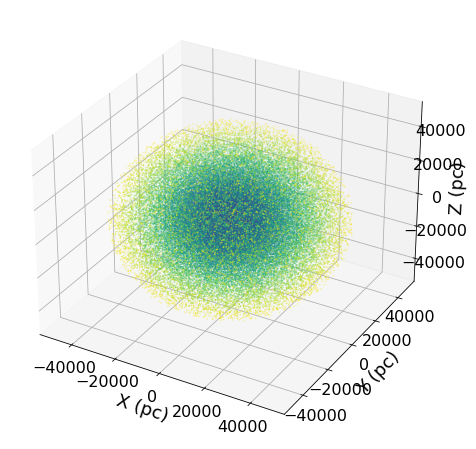

In [14]:
# 3D scatterplot of tracer star locations
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[0],mwHalo.cartesianPhaseSpacePoints[1],mwHalo.cartesianPhaseSpacePoints[2],c=mwHalo.radii,s=.1)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Colored by radius, from dark blue to yellow

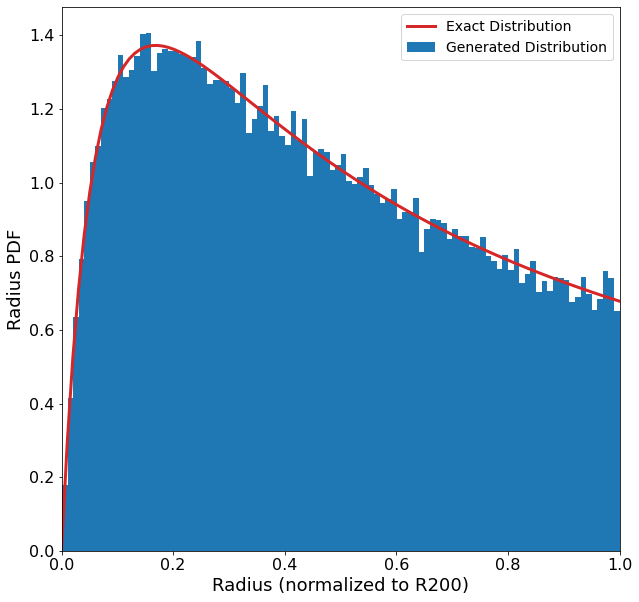

In [15]:
# Comparing the generated and theoretical probability distribution function for the halo radii.
fig, ax1 = plt.subplots(figsize=(10,10))

steps = 100

color = 'tab:blue'
ax1.set_xlabel('Radius (normalized to R200)')
ax1.set_ylabel('Radius PDF')
x_vals, bins, p=ax1.hist(mwHalo.radiiNorm,steps,color=color,density=True,label="Generated Distribution",align='mid')

color = 'tab:red'
r = np.linspace(0,1,steps)
pdf = []
for i in range(steps):
    pdf.append(NFW.radialPDF(r[i],mwHalo.haloAttributes))
ax1.plot(r,pdf, color=color,linewidth=3,label="Exact Distribution")
ax1.legend()
ax1.set_xlim(0,1)

plt.show()

<h2> Tracer Velocities</h2>

Text(0.5, 0, 'Vz (km/s)')

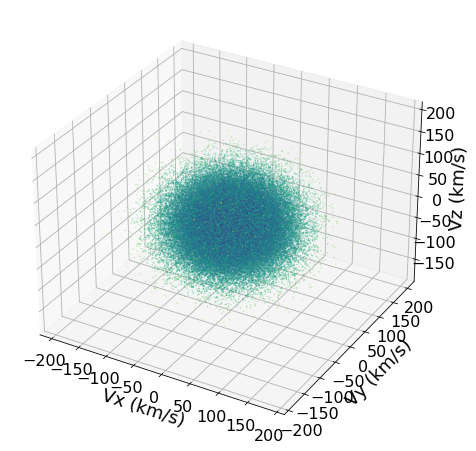

In [16]:
# 3D scatterplot of tracer star velocities
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[3],mwHalo.cartesianPhaseSpacePoints[4],mwHalo.cartesianPhaseSpacePoints[5],c=mwHalo.speeds,s=.1)
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_zlabel('Vz (km/s)')

# Colored by speed, from dark blue to yellow

In [17]:
# This cell finds the speed probability distribution function integrated over all radii. It steps through speeds, integrating over the PDF values for
# that speed at each radii before moving on to the next one. This cell is slow!

nTest = 50 # This can stay somewhat low, 100 is okay, don't go much higher.
PDF_over_r = np.zeros(nTest)
speedsList = np.linspace(0,np.max(mwHalo.speeds),nTest) # Starting at 0 will probably throw a roundoff error, ignore that...
for i in range(nTest):
    dispSquared = lambda normRad: NFW.radialVelocityDispersion(normRad,mwHalo.haloAttributes)
    PDF_over_r[i] = integrate.quad(lambda normRad: (1/(2*np.pi*dispSquared(normRad)**2))**(3/2)*(4*np.pi*speedsList[i]**2)*np.exp(-speedsList[i]**2/(2*dispSquared(normRad)**2)),0,1)[0]

C:\Users\ericr\Desktop\Rutgers\nfwHalo\nfwFunctions.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(lambda y: gFcn(y)/(y**3*(1+y)**2), c*radiusNorm, np.inf)[0]
C:\Users\ericr\Desktop\Rutgers\nfwHalo\nfwFunctions.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(lambda y: gFcn(y)/(y**3*(1+y)**2), c*radiusNorm, np.inf)[0]


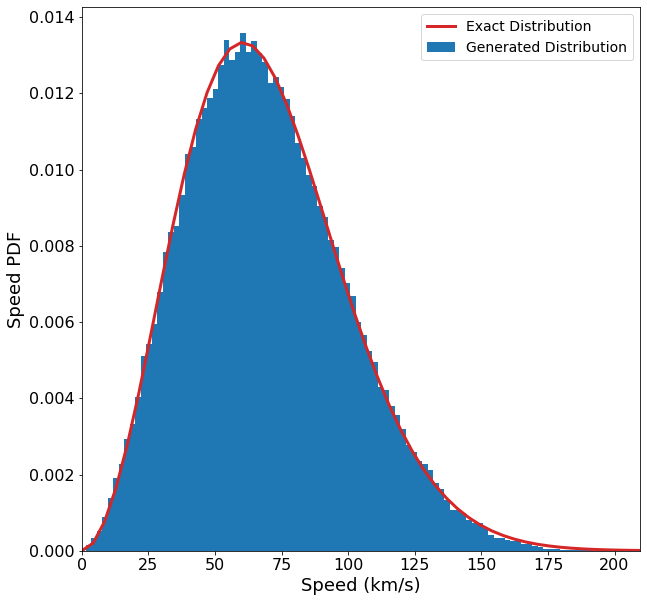

In [24]:
# Plotting the speed PDF integrated over all radii.
fig, ax1 = plt.subplots(figsize=(10,10))
color = 'tab:blue'
ax1.set_xlabel('Speed (km/s)')
ax1.set_ylabel('Speed PDF')
ax1.hist(mwHalo.speeds,100, color=color,density=True,label="Generated Distribution",align='left')

color = 'tab:red'
ax1.plot(speedsList, PDF_over_r, color=color,linewidth=3,label="Exact Distribution")
ax1.legend()
ax1.set_xlim(0,np.max(speedsList))

plt.show()

<h1>Spherical Velocities</h1>

<ipython-input-25-9be0bfd4a10b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  phiUnitVec = np.array((-mwHalo.cartesianPhaseSpacePoints[1]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),mwHalo.cartesianPhaseSpacePoints[0]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),0))


Text(0.5, 0, 'Phi Velocity (km/s)')

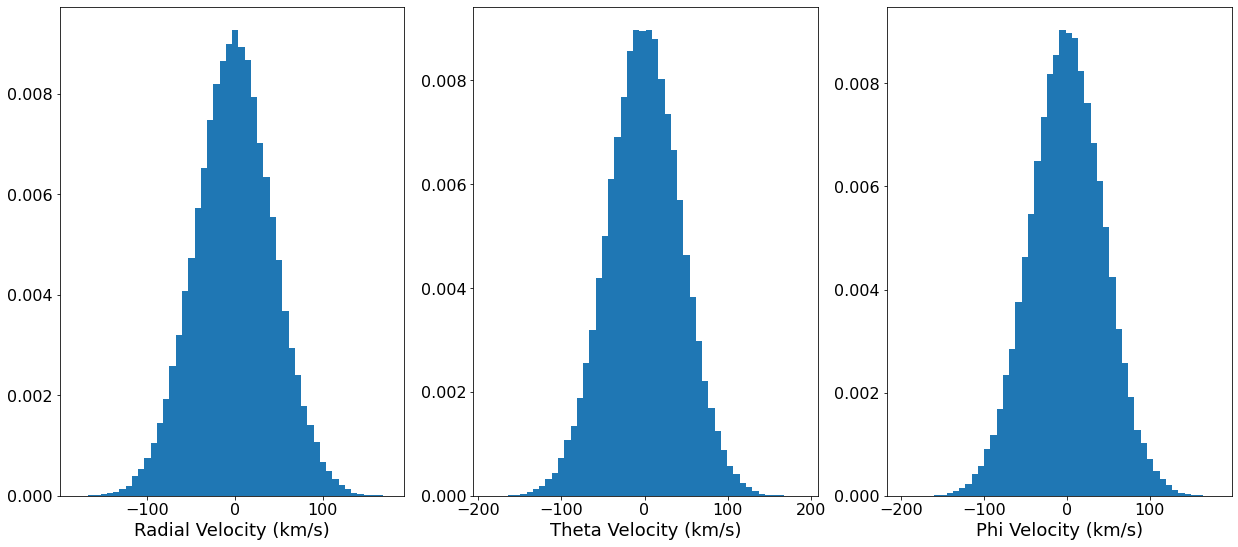

In [25]:
# Converting the velocities to spherical coordinates.
velVec = mwHalo.cartesianPhaseSpacePoints[3:6]
posVec = mwHalo.cartesianPhaseSpacePoints[0:3]

radVel = (mwHalo.cartesianPhaseSpacePoints[3]*mwHalo.cartesianPhaseSpacePoints[0] + mwHalo.cartesianPhaseSpacePoints[4]*mwHalo.cartesianPhaseSpacePoints[1] + mwHalo.cartesianPhaseSpacePoints[5]*mwHalo.cartesianPhaseSpacePoints[2])/mwHalo.radii
thetaUnitVec = np.array((mwHalo.cartesianPhaseSpacePoints[0]*mwHalo.cartesianPhaseSpacePoints[2],mwHalo.cartesianPhaseSpacePoints[1]*mwHalo.cartesianPhaseSpacePoints[2],-mwHalo.cartesianPhaseSpacePoints[0]**2-mwHalo.cartesianPhaseSpacePoints[1]**2)/(mwHalo.radii*np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2)))
thetaVel = mwHalo.cartesianPhaseSpacePoints[3]*thetaUnitVec[0] + mwHalo.cartesianPhaseSpacePoints[4]*thetaUnitVec[1] + mwHalo.cartesianPhaseSpacePoints[5]*thetaUnitVec[2]
phiUnitVec = np.array((-mwHalo.cartesianPhaseSpacePoints[1]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),mwHalo.cartesianPhaseSpacePoints[0]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),0))
phiVel = mwHalo.cartesianPhaseSpacePoints[3]*phiUnitVec[0] + mwHalo.cartesianPhaseSpacePoints[4]*phiUnitVec[1] + mwHalo.cartesianPhaseSpacePoints[5]*phiUnitVec[2]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,9))
ax1.hist(radVel,50,density=True)
ax1.set_xlabel('Radial Velocity (km/s)')
ax2.hist(thetaVel,50,density=True)
ax2.set_xlabel('Theta Velocity (km/s)')
ax3.hist(phiVel,50,density=True)
ax3.set_xlabel('Phi Velocity (km/s)')

<h1>Phase Space Analysis</h1>

First off, we're going to sample the phase space function defined in the NFWHalo class at a grid of values for radii and speed.

In [26]:
nr=160 # how many radii do we want to sample?
ns=160 # how many speeds do we want to sample?

normRadiusList = np.linspace(.000001,1,nr)
speedList = np.linspace(.000001,np.max(mwHalo.speeds),ns)
radGrid, speedGrid = np.meshgrid(normRadiusList,speedList,sparse=False, indexing='ij')

phaseSpaceGrid = np.zeros((nr,ns))
boxSize = (np.max(mwHalo.speeds)/ns)*(mwHalo.rDelta/nr) # has units of (km/s * pc)

updateInt = int(.1*nr)
for i in range(nr):
    if (i+1)%updateInt == 0:
        print("Calculation is "+str(100*(i+1)/nr)+" % done")
    for j in range(ns):
        phaseSpaceGrid[i,j] = boxSize*mwHalo.rDelta**2*(4*np.pi*radGrid[i,j]*speedGrid[i,j])**2*NFW.phaseSpaceDistributionFunction(radGrid[i,j],speedGrid[i,j],mwHalo.haloAttributes)

phaseSpaceIntApprox = np.sum(phaseSpaceGrid)
print(phaseSpaceIntApprox)

Calculation is 10.0 % done
Calculation is 20.0 % done
Calculation is 30.0 % done
Calculation is 40.0 % done
Calculation is 50.0 % done
Calculation is 60.0 % done
Calculation is 70.0 % done
Calculation is 80.0 % done
Calculation is 90.0 % done
Calculation is 100.0 % done
0.9894206203136939


I'm interested in how much the cutoff of velocities at the kinematic limit and the virial speed chops off occupied phase space. I can test this very easily by sampling this phase space function over the phase space we utilize (which is normalized by integrating over ALL 6D phase space) and seeing how much this discrete integration differs from 1.

Text(0, 0.5, '1 - phase space integral')

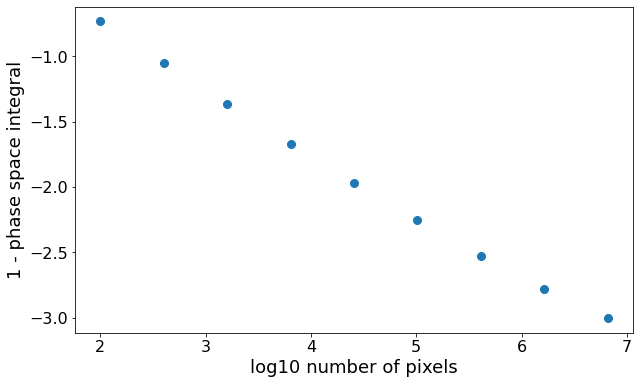

In [27]:
approxList = np.array((0.8156089020449218,0.9117045254879874,0.9569139256211714,0.9786084206934264,0.9892139747051578,0.9944552935872416,0.9970605665449931,0.9983593530340494,0.9990077835695818))
resolutionList = np.array((10**2,20**2,40**2,80**2,160**2,320**2,640**2,1280**2,2560**2))

plt.scatter(np.log10(resolutionList),np.log10(1-approxList))
plt.xlabel('log10 number of pixels')
plt.ylabel('1 - phase space integral')
# I think what this is telling me is that while there are of course diminishing returns here, this plot could probably maintain
# a relatively straight line for a few more data points before that slight curve starts to bottom this thing out. I don't know
# where it will bottom out at, but I think I would need far more computational power to reach the resolution required to completely
# eliminate sampling error.

# The purpose of this exercise was to see if sampling error would be subdominate to the error we subject ourselves to by cutting off the speed
# instead of taking it to infinity, which is what our function is technically normalized by. This tells me that the dominant error
# is just sampling error and that we do not need to worry about cutoff error. Good!

This tells me that very little of the occupied phase space is being cut off by placing a limit on the speed. This phase space density function seems to integrate to 1 (becomes arbitrarily close to 1) as we sample it more finely.

<h1>Comparing generated vs. theoretical phase space distributions</h1>

Text(0.5, 1.0, 'Generated (w/ theory overlaid as a contour)')

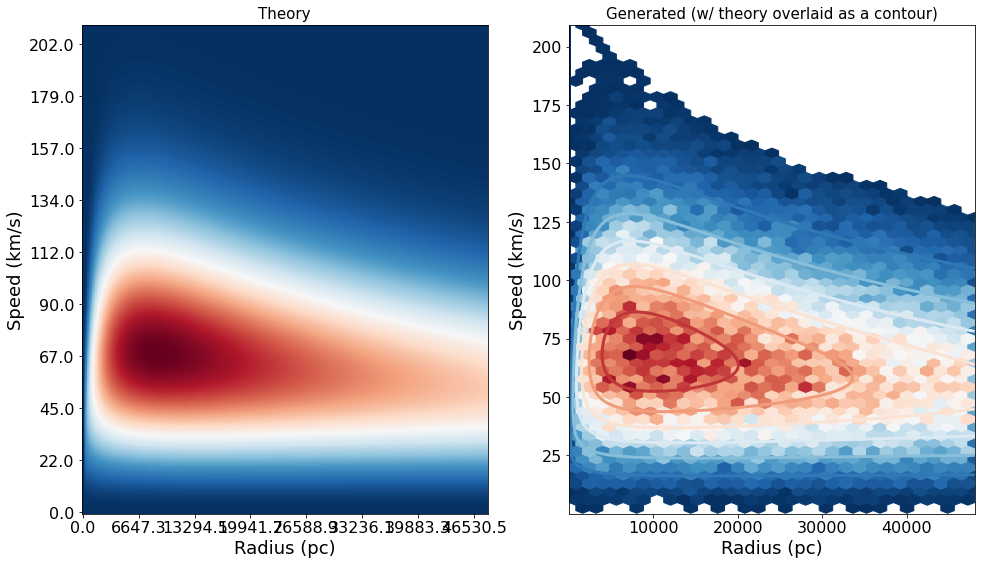

In [28]:
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(16,9))

ax1.imshow(np.transpose(phaseSpaceGrid),origin='lower',aspect='auto',cmap='RdBu_r')
ax1.set_ylabel('Speed (km/s)')
ax1.set_xlabel('Radius (pc)')
num_x_labels = 8
step_r = int(nr/(num_x_labels-1))
ax1.set_xticks(np.arange(0,nr,step_r))
ax1.set_xticklabels(np.round(mwHalo.rDelta*normRadiusList[::step_r],1))
num_y_labels = 10
step_s = int(ns/(num_y_labels-1))
ax1.set_yticks(np.arange(0,ns,step_s))
ax1.set_yticklabels(np.round(speedList[::step_s],0))
ax1.set_title('Theory')

ax2.hexbin(
    mwHalo.radii, 
    mwHalo.speeds,
    mincnt=1,gridsize=(30,30),cmap='RdBu_r'
)
x=mwHalo.rDelta*normRadiusList
y=speedList
ax2.contour(x,y,np.transpose(phaseSpaceGrid),cmap='RdBu_r',linewidths=3)
ax2.set_xlabel("Radius (pc)")
ax2.set_ylabel("Speed (km/s)")
ax2.set_title("Generated (w/ theory overlaid as a contour)")